In [1]:
%%bash
nrnivmodl # Compile NEURON model

/home/alex/Dropbox/Williams-etal-Synaptic-Transport/code/02_steady_state
h.mod kadist.mod kaprox.mod kdrca1.mod km.mod na3n.mod naxn.mod vecevent.mod
h.mod kadist.mod kaprox.mod kdrca1.mod km.mod na3n.mod naxn.mod vecevent.mod
"/home/alex/neuron/nrn/share/nrn/libtool"  --mode=compile gcc -DHAVE_CONFIG_H  -I. -I.. -I"/home/alex/neuron/nrn/include/nrn" -I"/home/alex/neuron/nrn/x86_64/lib"      -g -O2 -c -o mod_func.lo mod_func.c
libtool: compile:  gcc -DHAVE_CONFIG_H -I. -I.. -I/home/alex/neuron/nrn/include/nrn -I/home/alex/neuron/nrn/x86_64/lib -g -O2 -c mod_func.c  -fPIC -DPIC -o .libs/mod_func.o
"/home/alex/neuron/nrn/share/nrn/libtool"  --mode=link gcc -module  -g -O2    -o libnrnmech.la -rpath "/home/alex/neuron/nrn/x86_64/lib"  h.lo kadist.lo kaprox.lo kdrca1.lo km.lo na3n.lo naxn.lo vecevent.lo mod_func.lo  -L"/home/alex/neuron/nrn/x86_64/lib" -lnrnoc -loc -lmemacs -lnrnmpi -lscopmath -lsparse13 -lreadline -ltermcap -L"/home/alex/neuron/nrn/x86_64/lib" "/home/alex/neuron/nrn/x86_6

In [2]:
# Download NEURON: http://www.neuron.yale.edu/neuron/download
# Download PyNeuronToolbox: https://github.com/ahwillia/PyNeuron-Toolbox

from neuron import h
import numpy as np
import pylab as plt
from PyNeuronToolbox.record import ez_record,ez_convert
from PyNeuronToolbox.synapses import add_exp2
import time
%matplotlib inline
np.random.seed(123456789)


# Load morphology and other stuff
# --> SegLists: soma[2], dend[74], dend_5[37], apic[42], axon[1]
# --> Files from Migliore & Migliore (2012)
# --> CA1 pyramidal neuron
h.load_file('stdrun.hoc')
h.xopen('ri06.hoc')
h.xopen('fixnseg.hoc')
h.xopen('5a_nogui.hoc')
h.tstop = 700.0

# Function to get a random segment within a region of the dendrite
def randseg(region=None):
    tmp = np.random.uniform(0,1)
    if region is None:
        region = np.random.choice(['apic','dend_5','dend'])
    if region == 'apic':
        comp = h.apic[int(np.random.uniform(22,30))]
    elif region == 'dend_5':
        comp = h.dend_5[int(np.random.uniform(22,28))]
    elif region == 'dend':
        comp = h.dend[int(np.random.uniform(60,70))]
    return comp(tmp)

# Add a bunch of synapses
n_syn = 120
syn_rate = 50.0  # Hz
syndata = []
for i in range(n_syn): 
    spktimes = np.random.uniform(1,h.tstop-1,int(syn_rate*h.tstop/1e3))
    syndata.append(add_exp2(h,randseg(),spktimes,e=0,tau1=0.5,tau2=20,weight=0.001))

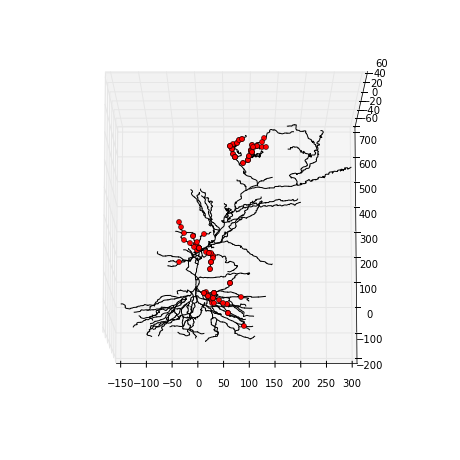

In [3]:
from PyNeuronToolbox.morphology import shapeplot, mark_locations
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=(8,8))
shapeax = plt.subplot(111, projection='3d')
shapeplot(h,shapeax,lw=1)
shapeax.view_init(elev=80,azim=-90)
for sd in syndata:
    s = sd[0] # synapse object (second group of synapses)
    mark_locations(h,s.get_segment().sec,s.get_loc(),'o',color='r',markersize=5)
plt.savefig('synloc.svg')
plt.show()

In [4]:
(v,v_labels) = ez_record(h,order='pre')
h.finitialize() # has to come after ez_record

start_time = time.time()
while h.t < h.tstop:
    h.fadvance()
elapsed_time = time.time() - start_time

v = ez_convert(v)
t = np.linspace(0,h.t,v.shape[0])

print 'Simulation time: ' + str(elapsed_time)
print 'Number of compartments: ' + str(v.shape[1])

Simulation time: 7.27225995064
Number of compartments: 742


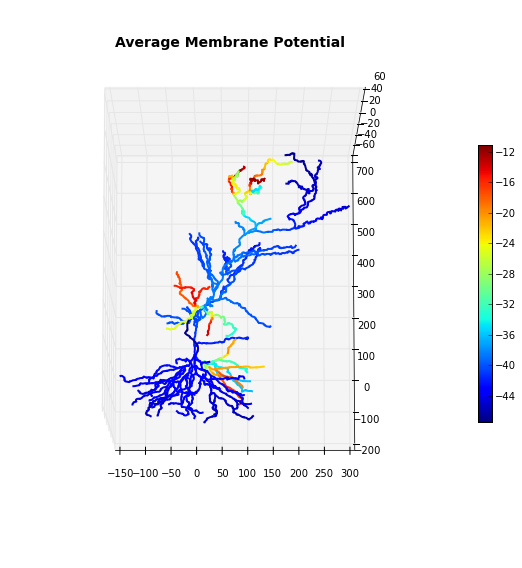

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.pyplot import cm

v_avg = np.mean(v,axis=0)
clim = [np.min(v_avg), np.max(v_avg)]

fig = plt.figure(figsize=(8,8))
shapeax = plt.subplot(111, projection='3d')
lines = shapeplot(h,shapeax,cvals=v_avg,clim=clim,\
                  cmap=plt.cm.jet,order='pre',lw=2)
shapeax.view_init(elev=80,azim=-90)
plt.title('Average Membrane Potential',fontweight='bold',fontsize=14)

# Hack to get a colorbar
# http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap=plt.cm.jet, norm=plt.Normalize(clim[0],clim[1])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()


In [6]:
n = len(v_avg)

def get_deriv(params,utarg):
    # Parse params
    out = list(params[0:(n-1)])
    into = list(params[(n-1):2*(n-1)])
    
    # Transport model is a linear system: du/dt = A*u
    # Sparsity pattern of matrix A encodes the morphology, entries are the trafficking rates
    A = np.zeros((n,n))
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            # Out of parent, into child
            out_rate = out.pop()
            A[p,p] += -out_rate
            A[i,p] += out_rate
            # Into parent, out of child
            in_rate = into.pop()
            A[p,i] += in_rate
            A[i,i] += -in_rate
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                out_rate = out.pop()
                in_rate = into.pop()
                # Out of parent, into child
                A[i-1,i-1] += -out_rate
                A[i,i-1] += out_rate
                # Into parent, out of child
                A[i-1,i] += in_rate
                A[i,i] += -in_rate
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # Return derivative based on trafficking rates
    return np.dot(A,utarg), A

def get_sys_matrix(x):
    in_rates = 1/(1+x**-1)
    out_rates = 1/(1+x)
    params = np.concatenate((out_rates,in_rates))
    mdot, A = get_deriv(params,utarg)
    return A

In [7]:
def set_transport_params(utarg):
    """
    Returns the ratio of parent/child concentration
    """
    # prepend to x because get_deriv pops from front
    x = []
    
    # Iterative traversal of dendritic tree in pre-order
    i = 0
    section = None
    parentStack = [(None,h.soma[0])]
    while len(parentStack)>0:
        # Get next section to traverse
        #  --> p is parent index, section is h.Section object
        (p,section) = parentStack.pop()
        
        # Trafficking to/from parent
        if p is not None:
            mp = utarg[p] # concentration in parent
            mc = utarg[i] # concentration in child
            x.insert(0,mp/mc)
        
        # visit all segments in compartment
        for (j,seg) in enumerate(section):
            # Deal with out/into rates within compartment, just tridiag matrix
            if j>0:
                mp = utarg[i-1]
                mc = utarg[i]
                x.insert(0,mp/mc)
                
            # move onto next compartment
            i += 1
        
        # now visit children in pre-order
        child_list = list(h.SectionRef(sec=section).child)
        if child_list is not None:
            child_list.reverse()
        for c_sec in child_list:
            parentStack.append([i-1,c_sec]) # append parent index and child
    
    # return calculated guesses (flip, up/down since get_deriv pops from start)
    return np.array(x)

In [8]:
# Find trafficking rates to reproduce spatial pattern of average membrane potential

# Target spatial distribution:
utarg = (v_avg-np.min(v_avg))/(np.max(v_avg)-np.min(v_avg))*0.9 + 0.1
print len(utarg)

742


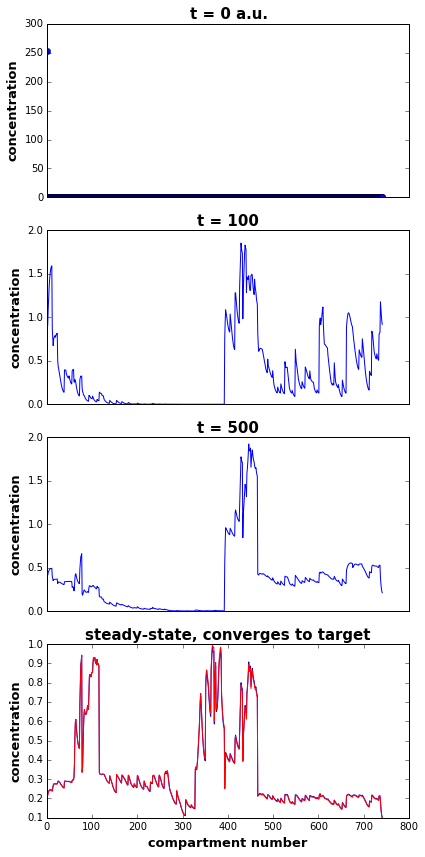

In [9]:
## Simulation showing that the correct concentration distribution emerges over time
from scipy.linalg import expm  # matrix exponential used to solve linear system
A = get_sys_matrix(set_transport_params(utarg))

# initial condition, u starts only in soma and is trafficked out to dendrites
u0 = np.zeros(n)
u0[0] = sum(utarg)  # compartment 0 is the soma

plt.figure(figsize=(6,12))
plt.subplot(4,1,1)
plt.title('t = 0 a.u.',fontsize=15,fontweight='bold')
plt.ylabel('concentration',fontsize=13,fontweight='bold')
plt.plot(u0,'-ob')
plt.xticks([])

plt.subplot(4,1,2)
plt.plot(np.dot(expm(100.0*A),u0),'-b')
plt.title('t = 100',fontsize=15,fontweight='bold')
plt.ylabel('concentration',fontsize=13,fontweight='bold')
plt.xticks([])

plt.subplot(4,1,3)
plt.plot(np.dot(expm(500.0*A),u0),'-b')
plt.title('t = 500',fontsize=15,fontweight='bold')
plt.ylabel('concentration',fontsize=13,fontweight='bold')
plt.xticks([])

plt.subplot(4,1,4)
plt.plot(np.dot(expm(3e4*A),u0),'-b')
plt.plot(utarg,'-r')
plt.title('steady-state, converges to target',fontsize=15,fontweight='bold')
plt.ylabel('concentration',fontsize=13,fontweight='bold')
plt.xlabel('compartment number',fontsize=13,fontweight='bold')

plt.tight_layout()
plt.savefig('CA1_ordered.svg')
plt.show()

In [10]:
# Run a simulation (log time)
# --> this is a linear system; thus, matrix exponential provides exact solution
nframes = 10
u = [u0]
t = np.logspace(-1,7,nframes)
for tt in t:
    u.append(np.dot(expm(tt*A),u0))
u = np.array(u)

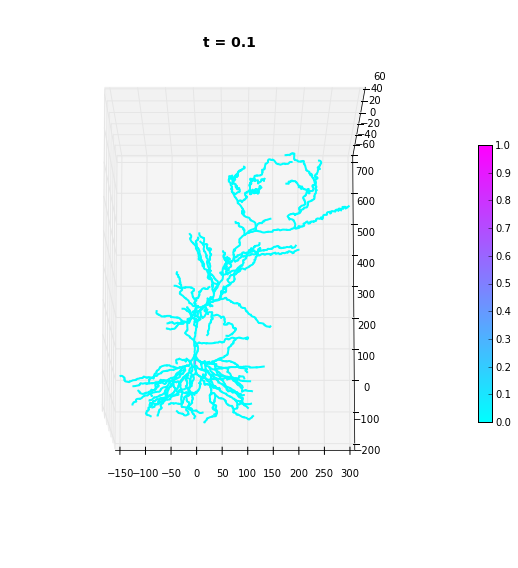

In [11]:
## Plot t[0], first time point 
clim = [0,1]

fig = plt.figure(figsize=(8,8))
shapeax = plt.subplot(111, projection='3d')
lines = shapeplot(h,shapeax,cvals=u[0,:],clim=clim,\
                  cmap=plt.cm.cool,order='pre',lw=2)
shapeax.view_init(elev=80,azim=-90)
plt.title('t = '+str(t[0]),fontweight='bold',fontsize=14)

# colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()
#plt.savefig('ca1_t0.svg')

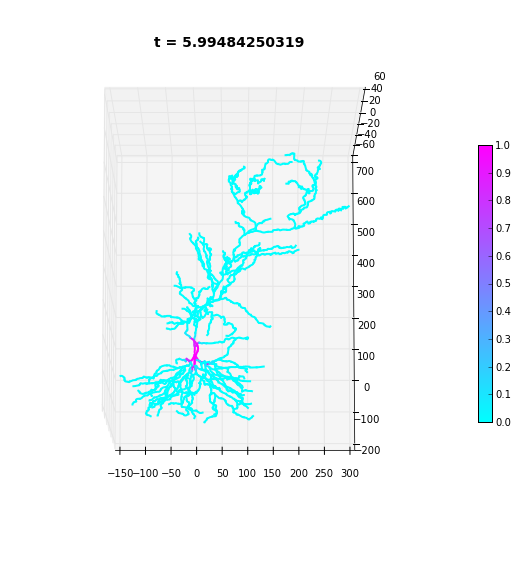

In [12]:
## Plot t[2], second time point
clim = [0,1]

fig = plt.figure(figsize=(8,8))
shapeax = plt.subplot(111, projection='3d')
lines = shapeplot(h,shapeax,cvals=u[2,:],clim=clim,\
                  cmap=plt.cm.cool,order='pre',lw=2)
shapeax.view_init(elev=80,azim=-90)
plt.title('t = '+str(t[2]),fontweight='bold',fontsize=14)

# colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()
#plt.savefig('ca1_t1.svg')

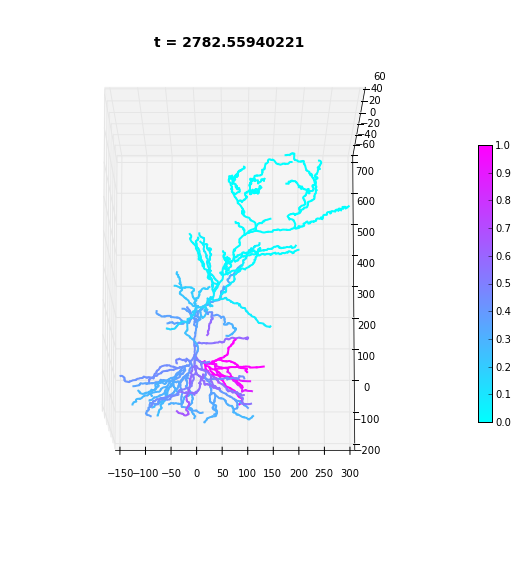

In [13]:
## Plot t[5], third time point
clim = [0,1]

fig = plt.figure(figsize=(8,8))
shapeax = plt.subplot(111, projection='3d')
lines = shapeplot(h,shapeax,cvals=u[5,:],clim=clim,\
                  cmap=plt.cm.cool,order='pre',lw=2)
shapeax.view_init(elev=80,azim=-90)
plt.title('t = '+str(t[5]),fontweight='bold',fontsize=14)

# colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()
#plt.savefig('ca1_t2.svg')

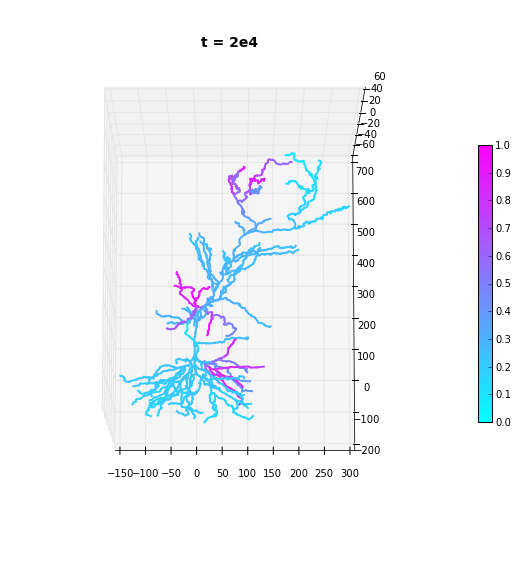

In [14]:
## Plot steady-state distribution
clim = [0,1]

fig = plt.figure(figsize=(8,8))
shapeax = plt.subplot(111, projection='3d')
lines = shapeplot(h,shapeax,cvals=np.dot(expm(2e4*A),u0),clim=clim,\
                  cmap=plt.cm.cool,order='pre',lw=2)
shapeax.view_init(elev=80,azim=-90)
plt.title('t = 2e4',fontweight='bold',fontsize=14)

# colorbar
sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()
#plt.savefig('ca1_ss.svg')


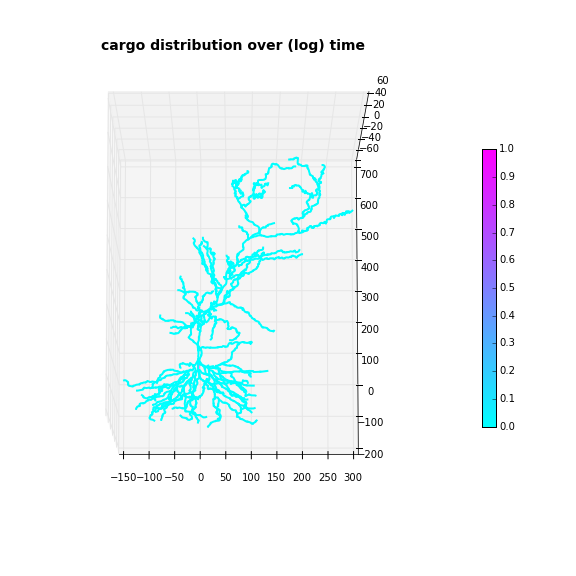
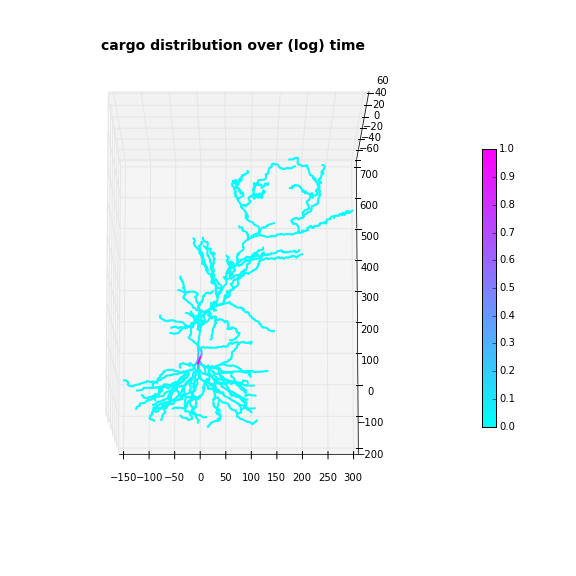
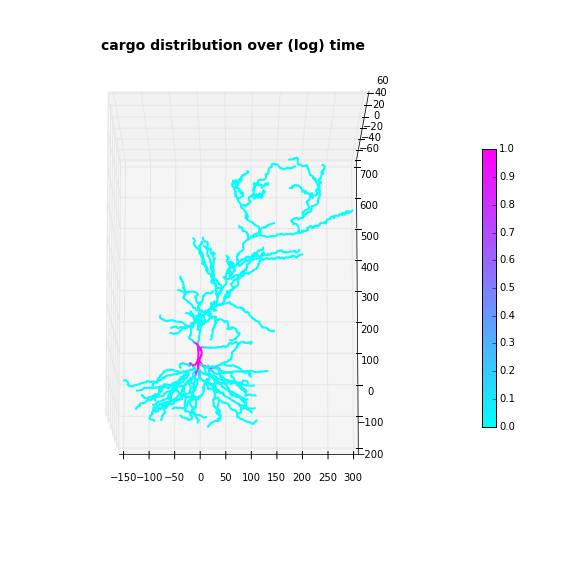
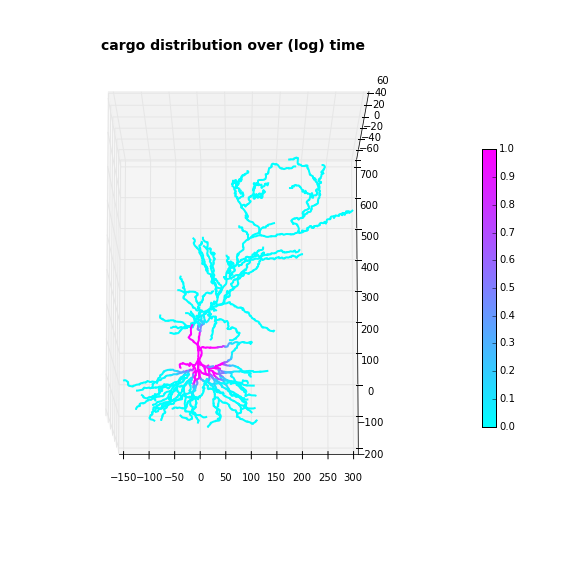
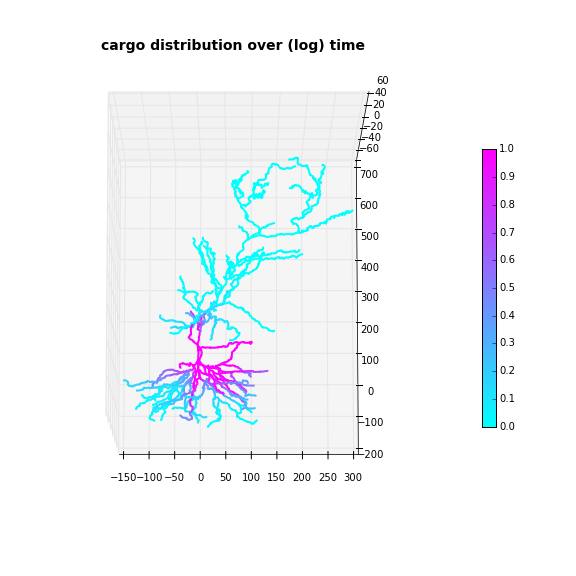
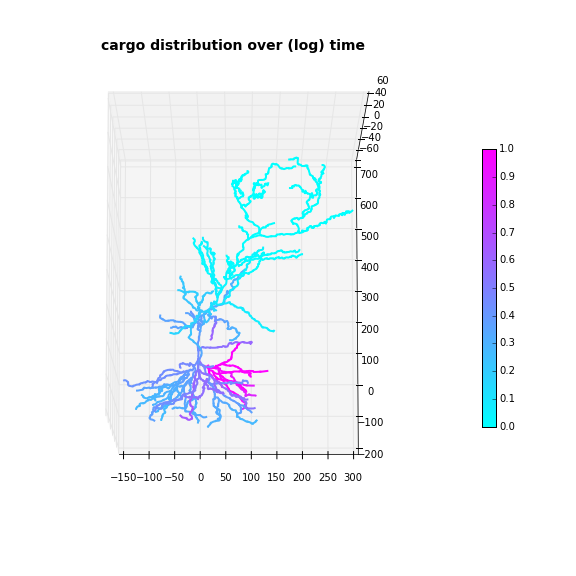
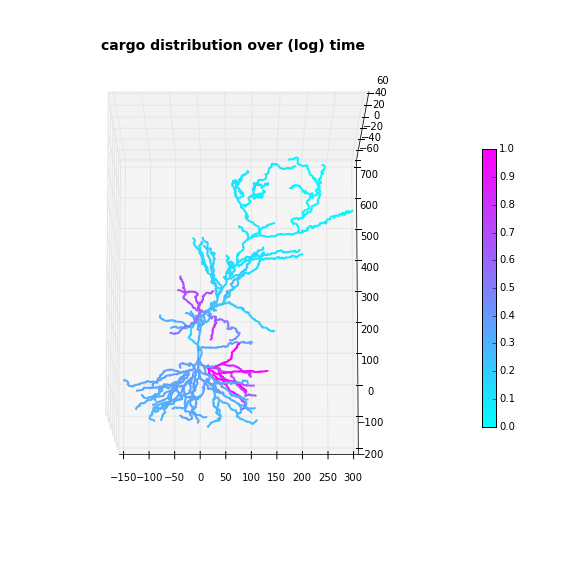
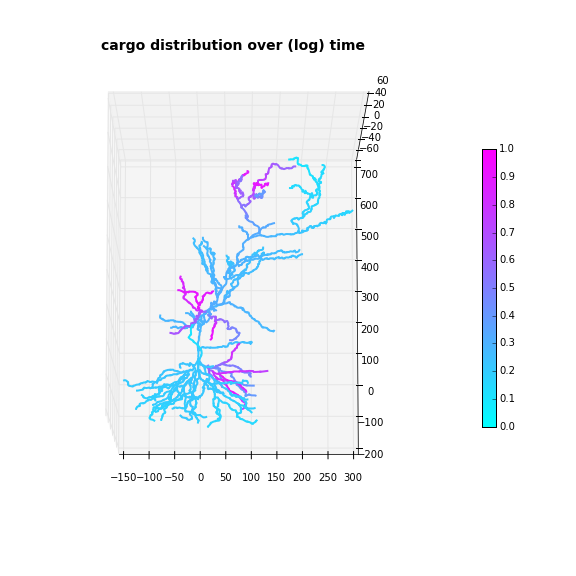
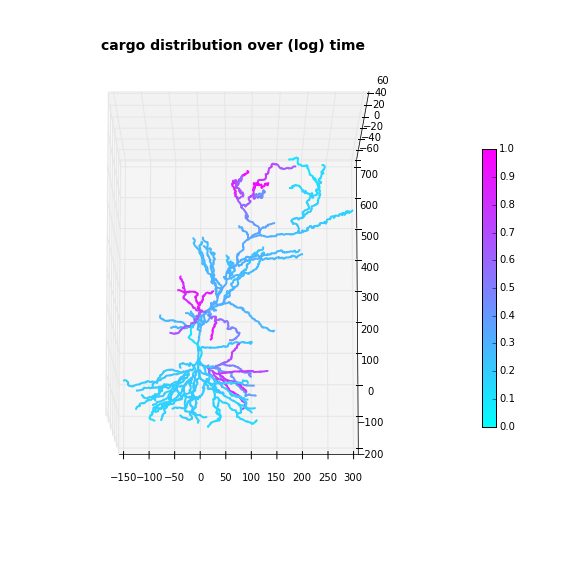
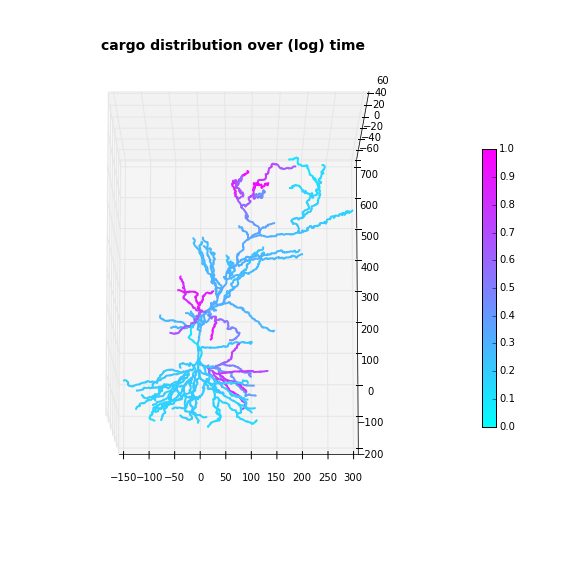

In [15]:
## Make an animation to show the convergence
from PyNeuronToolbox.morphology import shapeplot_animate
from JSAnimation import IPython_display
from matplotlib import animation

clim = clim = [0,1]

# Make an animation
fig = plt.figure(figsize=(8,8))
shapeax = plt.subplot(111, projection='3d')
lines = shapeplot(h,shapeax,order='pre',lw=2)
shapeax.view_init(elev=80,azim=-90)
plt.title('cargo distribution over (log) time',fontweight='bold',fontsize=14)

# Hack to get a colorbar
# http://stackoverflow.com/questions/8342549/matplotlib-add-colorbar-to-a-sequence-of-line-plots
sm = plt.cm.ScalarMappable(cmap=plt.cm.cool, norm=plt.Normalize(clim[0],clim[1])) 
sm._A = []
plt.colorbar(sm, shrink=0.5)
plt.tight_layout()

anim_func = shapeplot_animate(u,lines,nframes,clim=clim,cmap=cm.cool)
anim = animation.FuncAnimation(fig, anim_func, frames=nframes, interval=400, blit=True)
#anim.save('CA1_Transport_Supp_Video.mp4', fps=30)
anim